In [1]:
from copy import deepcopy 

import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

from SmithZero import D2torchEngine

In [2]:
torch.manual_seed(42)

## Data Preparation 

In [3]:
from torchvision.datasets import CIFAR10 
import torchvision.transforms as T


# === data transformation === # 
train_T = T.Compose([   T.RandomCrop(32, padding=4),
                        T.RandomHorizontalFlip(), 
                        T.ToTensor(), 
                        T.Normalize(mean= (0.4914, 0.4822, 0.4465),
                                    std=(0.2023, 0.1994, 0.2010)),
                    ])

test_T = T.Compose([T.ToTensor(),
                    T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                std=(0.2023, 0.1994, 0.2010))
                    ])                  


# === download dataset object === # 
train_data = CIFAR10 (  root="./dataset/train",
                        train=True,
                        download=True,
                        transform=train_T )

test_data = CIFAR10 (   root="./dataset/test",
                        train=False,
                        download=True, 
                        transform=test_T )  

Files already downloaded and verified
Files already downloaded and verified


## Data Batching 

In [4]:
from torch.utils.data import DataLoader

trainloader = DataLoader(train_data,
                        batch_size=124,
                        shuffle=True, 
                        num_workers=4 
                        )

testloader = DataLoader(test_data,
                        batch_size=124,
                        num_workers=4
                        )

## Model Design

In [5]:
class LeNet(nn.Module):
    def __init__(self, in_channels=3, n_class=10, p=0.5):
        super(LeNet, self).__init__()
        self.p = p # probability for DropOut layer 
        
        # === Create the convolution layers === # 
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, padding=2)
        self.c3 = nn.Conv2d(6, 16, 5) 
        self.c5 = nn.Conv2d(16, 120, 5) 

        # === Create the linear layers === # 
        self.f6 = nn.Linear(in_features=480, out_features=84)
        self.output = nn.Linear(in_features=84, out_features=n_class)

        # === Create dropout layers === # 
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # === block1 === # 
        x = self.c1(x)
        x = F.relu(x) 
        x = F.max_pool2d(x, kernel_size=2)
        # === block2 === # 
        x = self.c3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # === block3 === # 
        x = self.c5(x)
        x = F.relu(x)
        # ==== flattening === #
        x = nn.Flatten()(x)
        return x 

    def classifier(self, x): 
        # === hidden layler === # 
        if self.p > 0: 
            x = self.drop(x)        
        x = self.f6(x)
        x = F.relu(x)

        # === output layer === # 
        if self.p > 0 :
            x = self.drop(x)
        x = self.output(x)
        return x 
    
    def forward(self, x):
        x = self.featurizer(x) # return (1, 480)
        x = self.classifier(x) # return (1, 10)
        return x 

***
## W&B setup

In [6]:
# === hyperparameter dict === # 
# you can receive with .yaml or .json 

hyperparams = dict(
        seed=42, 
        epochs=50,
        classes=10,
        batch_size=128,
        n_workers=4,
        learning_rate=1e-3,
        dropout_p = 0.5,
        dataset="CIFAR10",
        architecture="LeNet")

In [7]:
import wandb 

wandb.login() 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: doranlyong (use `wandb login --relogin` to force relogin)


True

In [8]:
proj_name = "LeNet-cifar10"

wandb.init(project=proj_name, config=hyperparams)
config = wandb.config 

/home/milky/anaconda3/envs/py38/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


## Model Configuration

In [9]:
model = LeNet(in_channels=3, n_class=config.classes, p=config.dropout_p)

loss_fn = nn.CrossEntropyLoss(reduction='mean') 
optimizer = optim.Adam( model.parameters(), # (!) be sure to pass in the model.parameters() 
                        lr=config.learning_rate, 
                    ) 

In [10]:
AgentDL = D2torchEngine(model, loss_fn, optimizer)

AgentDL.set_loaders(trainloader, testloader)
AgentDL.set_wandb(wandb)

100%|██████████| 100/100 [00:01<00:00, 94.88it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.05E-03


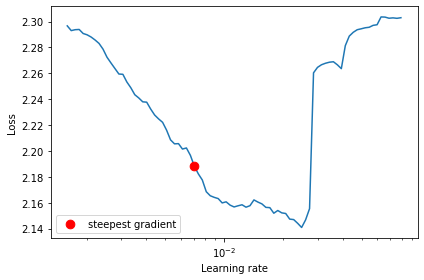

In [11]:
# === Learning Rate Range Test === # 
fig = AgentDL.lr_range_test(end_lr=1e-1, num_iter=100)

In [12]:
# === reset the optimzier === # 
reset_optimizer = optim.Adam(  model.parameters(), lr=5.34e-3) 
AgentDL.set_optimizer(reset_optimizer) 

## Set a scheduler 

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

scheduler = CosineAnnealingWarmRestarts(reset_optimizer, T_0=20, T_mult=4, eta_min=1e-5, last_epoch= -1, verbose=False)

AgentDL.set_lr_scheduler(scheduler)

In [14]:
AgentDL.optimizer == AgentDL.scheduler.optimizer

True

## Model Training 

In [15]:
AgentDL.train(n_epochs=100, seed=config.seed)

100%|██████████| 100/100 [08:08<00:00,  4.89s/it]


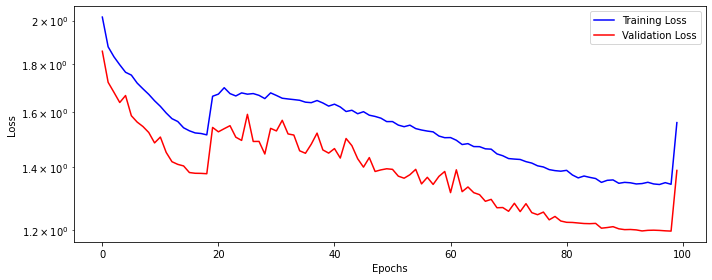

In [16]:
fig = AgentDL.plot_losses()